# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
# data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

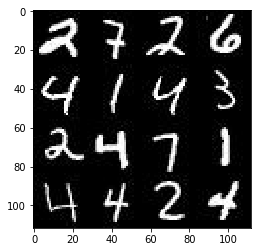

In [2]:
show_n_images = 23

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

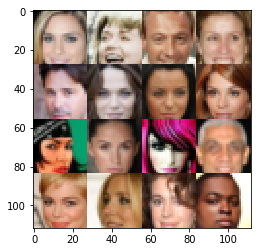

In [3]:
show_n_images = 23

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
celeba_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(celeba_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels)) 
    z_data = tf.placeholder(tf.float32, (None, z_dim))
    learning_rate = tf.placeholder(tf.float32, shape=())
    return(input_real, z_data, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2, keep_prob=0.75):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    with tf.variable_scope('discriminator', reuse=reuse):

        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        logits = tf.layers.dense(tf.reshape(relu3, (-1, 4*4*256)), 1)
        
        return(tf.sigmoid(logits), logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2, keep_prob=0.75):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    with tf.variable_scope('generator', reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 256))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d_transpose(x1, 128, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)

        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
 
        return(tf.tanh(logits))
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return(d_loss, g_loss)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return(d_train_opt, g_train_opt)
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, 
          beta1, get_batches, data_shape, data_image_mode, 
          print_every=100, show_every=500, show_n_images=25):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """

    # Build the model
    image_width, image_height, image_channels = data_shape[1:]
    input_real, input_z, lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels, alpha=0.2)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)


    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())

        steps = 0
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images *= 2  # normalize input to discriminator
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                food = {lr: learning_rate, input_real: batch_images, input_z: batch_z}
                _ = sess.run(d_train_opt, feed_dict=food)
                _ = sess.run(g_train_opt, feed_dict=food)

                # Output pogress information
                if steps % show_every == 0:
                    show_generator_output(sess, show_n_images, input_z, image_channels, data_image_mode)
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                
                # Increment number of given steps so far
                steps += 1

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

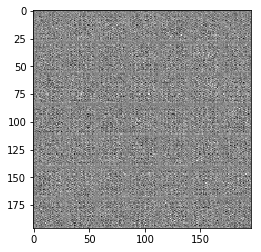

Epoch 1/2... Discriminator Loss: 3.1545... Generator Loss: 0.0538
Epoch 1/2... Discriminator Loss: 0.9667... Generator Loss: 0.7126
Epoch 1/2... Discriminator Loss: 0.8314... Generator Loss: 0.7373
Epoch 1/2... Discriminator Loss: 0.6863... Generator Loss: 1.0013
Epoch 1/2... Discriminator Loss: 0.7276... Generator Loss: 1.4251


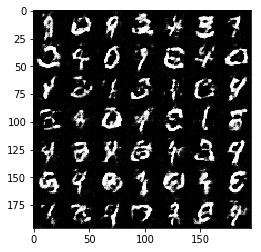

Epoch 1/2... Discriminator Loss: 0.6237... Generator Loss: 1.2352
Epoch 1/2... Discriminator Loss: 0.7518... Generator Loss: 0.9914
Epoch 1/2... Discriminator Loss: 0.6249... Generator Loss: 1.2780
Epoch 1/2... Discriminator Loss: 0.5995... Generator Loss: 1.2922
Epoch 1/2... Discriminator Loss: 0.5083... Generator Loss: 1.4930


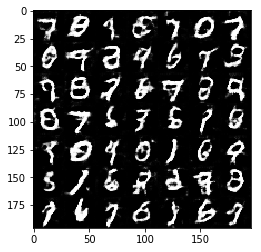

Epoch 1/2... Discriminator Loss: 0.7327... Generator Loss: 1.4639
Epoch 1/2... Discriminator Loss: 0.5766... Generator Loss: 1.3138
Epoch 1/2... Discriminator Loss: 1.0114... Generator Loss: 1.8598
Epoch 1/2... Discriminator Loss: 0.5184... Generator Loss: 1.8064
Epoch 1/2... Discriminator Loss: 0.6788... Generator Loss: 0.9921


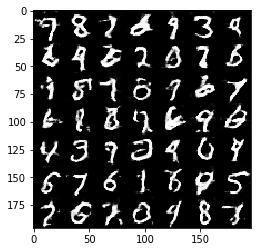

Epoch 1/2... Discriminator Loss: 0.9821... Generator Loss: 0.6773
Epoch 1/2... Discriminator Loss: 0.4463... Generator Loss: 1.3877
Epoch 1/2... Discriminator Loss: 0.6369... Generator Loss: 1.7443
Epoch 1/2... Discriminator Loss: 0.7835... Generator Loss: 0.8464
Epoch 2/2... Discriminator Loss: 0.7722... Generator Loss: 0.9412


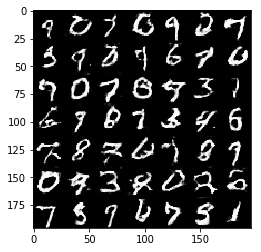

Epoch 2/2... Discriminator Loss: 0.7328... Generator Loss: 0.9314
Epoch 2/2... Discriminator Loss: 0.8696... Generator Loss: 2.0778
Epoch 2/2... Discriminator Loss: 0.9121... Generator Loss: 0.7085
Epoch 2/2... Discriminator Loss: 1.5625... Generator Loss: 0.3565
Epoch 2/2... Discriminator Loss: 1.7188... Generator Loss: 0.2651


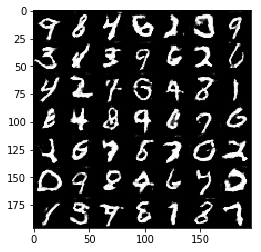

Epoch 2/2... Discriminator Loss: 0.6369... Generator Loss: 1.1119
Epoch 2/2... Discriminator Loss: 0.8039... Generator Loss: 0.8452
Epoch 2/2... Discriminator Loss: 1.5020... Generator Loss: 0.3616
Epoch 2/2... Discriminator Loss: 0.8076... Generator Loss: 0.8887
Epoch 2/2... Discriminator Loss: 0.8187... Generator Loss: 0.7705


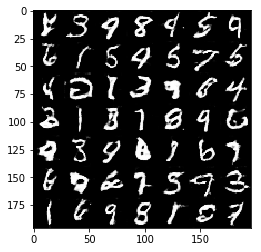

Epoch 2/2... Discriminator Loss: 0.3376... Generator Loss: 1.9988
Epoch 2/2... Discriminator Loss: 0.8923... Generator Loss: 0.7549
Epoch 2/2... Discriminator Loss: 0.5178... Generator Loss: 1.2504
Epoch 2/2... Discriminator Loss: 0.3343... Generator Loss: 1.9898
Epoch 2/2... Discriminator Loss: 0.5036... Generator Loss: 1.9580


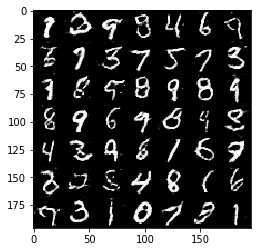

Epoch 2/2... Discriminator Loss: 0.6069... Generator Loss: 1.2046
Epoch 2/2... Discriminator Loss: 0.4396... Generator Loss: 1.4954
Epoch 2/2... Discriminator Loss: 0.6828... Generator Loss: 0.9225


In [12]:
batch_size = 32
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

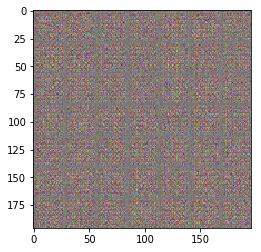

Epoch 1/1... Discriminator Loss: 6.0662... Generator Loss: 0.0030
Epoch 1/1... Discriminator Loss: 0.5415... Generator Loss: 1.8823
Epoch 1/1... Discriminator Loss: 1.3634... Generator Loss: 0.4781
Epoch 1/1... Discriminator Loss: 1.0030... Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 1.5762... Generator Loss: 0.4179


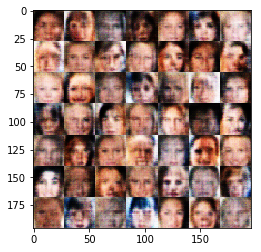

Epoch 1/1... Discriminator Loss: 0.9735... Generator Loss: 0.7591
Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.7614
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 0.6011
Epoch 1/1... Discriminator Loss: 1.0553... Generator Loss: 0.6616
Epoch 1/1... Discriminator Loss: 1.0512... Generator Loss: 0.7516


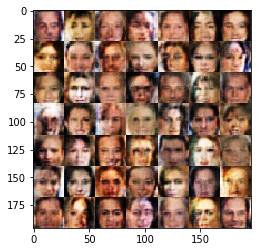

Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.4269
Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 0.5456
Epoch 1/1... Discriminator Loss: 0.5920... Generator Loss: 3.4800
Epoch 1/1... Discriminator Loss: 1.2069... Generator Loss: 0.4759
Epoch 1/1... Discriminator Loss: 0.7349... Generator Loss: 3.7601


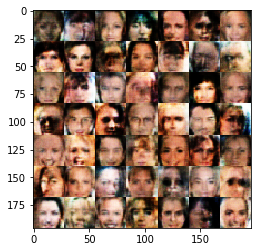

Epoch 1/1... Discriminator Loss: 0.0712... Generator Loss: 4.8605
Epoch 1/1... Discriminator Loss: 0.0274... Generator Loss: 7.4296
Epoch 1/1... Discriminator Loss: 0.0648... Generator Loss: 3.9790
Epoch 1/1... Discriminator Loss: 0.0471... Generator Loss: 3.9837
Epoch 1/1... Discriminator Loss: 0.3574... Generator Loss: 1.4801


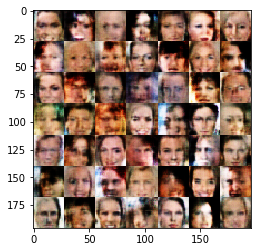

Epoch 1/1... Discriminator Loss: 0.0956... Generator Loss: 3.3422
Epoch 1/1... Discriminator Loss: 0.2069... Generator Loss: 6.6491
Epoch 1/1... Discriminator Loss: 0.2511... Generator Loss: 1.8841
Epoch 1/1... Discriminator Loss: 0.0033... Generator Loss: 8.5808
Epoch 1/1... Discriminator Loss: 0.4305... Generator Loss: 1.2674


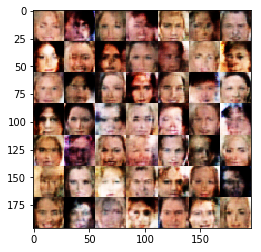

Epoch 1/1... Discriminator Loss: 0.0185... Generator Loss: 5.8958
Epoch 1/1... Discriminator Loss: 0.0175... Generator Loss: 5.2847
Epoch 1/1... Discriminator Loss: 0.0162... Generator Loss: 5.1850
Epoch 1/1... Discriminator Loss: 0.0332... Generator Loss: 4.3823
Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 7.5381


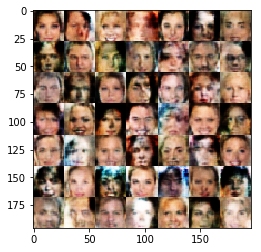

Epoch 1/1... Discriminator Loss: 0.3237... Generator Loss: 1.6735
Epoch 1/1... Discriminator Loss: 0.0546... Generator Loss: 6.0211
Epoch 1/1... Discriminator Loss: 0.1241... Generator Loss: 6.3968
Epoch 1/1... Discriminator Loss: 0.0957... Generator Loss: 3.0380
Epoch 1/1... Discriminator Loss: 0.3271... Generator Loss: 1.7750


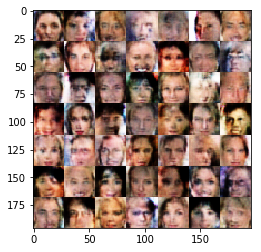

Epoch 1/1... Discriminator Loss: 0.4723... Generator Loss: 1.3562
Epoch 1/1... Discriminator Loss: 0.0833... Generator Loss: 2.8985
Epoch 1/1... Discriminator Loss: 0.0414... Generator Loss: 8.0852
Epoch 1/1... Discriminator Loss: 0.0561... Generator Loss: 3.8950
Epoch 1/1... Discriminator Loss: 0.0232... Generator Loss: 4.5517


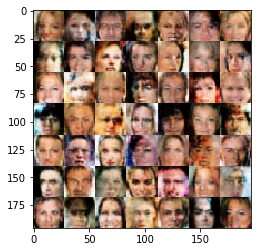

Epoch 1/1... Discriminator Loss: 0.6254... Generator Loss: 0.9267
Epoch 1/1... Discriminator Loss: 0.5927... Generator Loss: 1.2856
Epoch 1/1... Discriminator Loss: 0.0575... Generator Loss: 3.4751
Epoch 1/1... Discriminator Loss: 0.1566... Generator Loss: 2.5735
Epoch 1/1... Discriminator Loss: 0.0298... Generator Loss: 4.8066


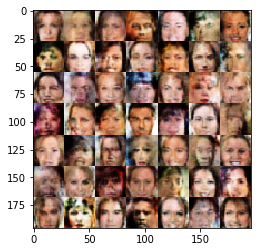

Epoch 1/1... Discriminator Loss: 0.9237... Generator Loss: 0.7348
Epoch 1/1... Discriminator Loss: 0.4214... Generator Loss: 1.3330
Epoch 1/1... Discriminator Loss: 0.0142... Generator Loss: 6.2854
Epoch 1/1... Discriminator Loss: 0.1746... Generator Loss: 2.4666
Epoch 1/1... Discriminator Loss: 0.0261... Generator Loss: 5.1924


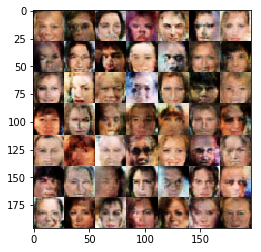

Epoch 1/1... Discriminator Loss: 2.8837... Generator Loss: 0.1003
Epoch 1/1... Discriminator Loss: 0.8458... Generator Loss: 2.3030
Epoch 1/1... Discriminator Loss: 0.6603... Generator Loss: 1.0500
Epoch 1/1... Discriminator Loss: 0.7315... Generator Loss: 1.2180
Epoch 1/1... Discriminator Loss: 0.0437... Generator Loss: 5.5002


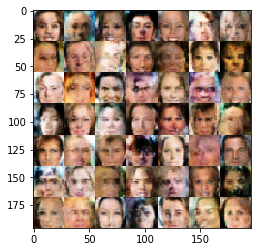

Epoch 1/1... Discriminator Loss: 0.0395... Generator Loss: 4.9202
Epoch 1/1... Discriminator Loss: 0.0398... Generator Loss: 4.1471
Epoch 1/1... Discriminator Loss: 0.1600... Generator Loss: 2.4718
Epoch 1/1... Discriminator Loss: 0.0386... Generator Loss: 7.7433
Epoch 1/1... Discriminator Loss: 0.1449... Generator Loss: 2.7477


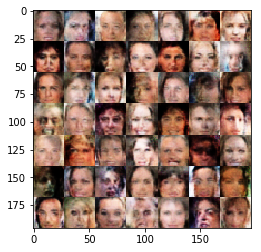

Epoch 1/1... Discriminator Loss: 0.1010... Generator Loss: 3.0989
Epoch 1/1... Discriminator Loss: 0.3671... Generator Loss: 3.1254
Epoch 1/1... Discriminator Loss: 0.0241... Generator Loss: 5.1857
Epoch 1/1... Discriminator Loss: 0.0292... Generator Loss: 7.1481
Epoch 1/1... Discriminator Loss: 0.0209... Generator Loss: 6.0868


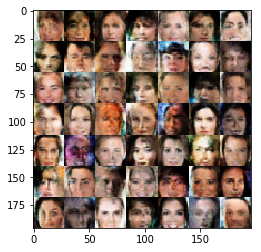

Epoch 1/1... Discriminator Loss: 0.0958... Generator Loss: 2.9114
Epoch 1/1... Discriminator Loss: 1.1019... Generator Loss: 0.6521
Epoch 1/1... Discriminator Loss: 1.8729... Generator Loss: 0.2715
Epoch 1/1... Discriminator Loss: 0.0898... Generator Loss: 3.6773
Epoch 1/1... Discriminator Loss: 0.0722... Generator Loss: 3.4096


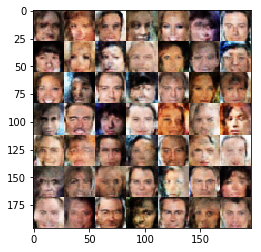

Epoch 1/1... Discriminator Loss: 0.0876... Generator Loss: 3.1675
Epoch 1/1... Discriminator Loss: 0.1967... Generator Loss: 2.2557
Epoch 1/1... Discriminator Loss: 0.0273... Generator Loss: 5.2430
Epoch 1/1... Discriminator Loss: 0.0848... Generator Loss: 4.2518
Epoch 1/1... Discriminator Loss: 0.4999... Generator Loss: 1.2714


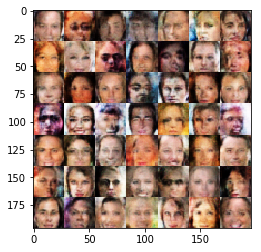

Epoch 1/1... Discriminator Loss: 0.4707... Generator Loss: 1.3974
Epoch 1/1... Discriminator Loss: 3.0782... Generator Loss: 0.0668
Epoch 1/1... Discriminator Loss: 0.3202... Generator Loss: 1.7040
Epoch 1/1... Discriminator Loss: 0.0899... Generator Loss: 3.4862
Epoch 1/1... Discriminator Loss: 0.0103... Generator Loss: 6.0943


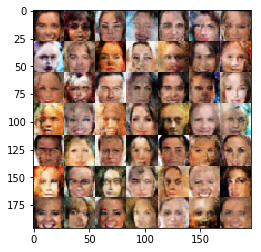

Epoch 1/1... Discriminator Loss: 0.0100... Generator Loss: 5.2442
Epoch 1/1... Discriminator Loss: 0.1529... Generator Loss: 2.6947
Epoch 1/1... Discriminator Loss: 0.0300... Generator Loss: 5.6147
Epoch 1/1... Discriminator Loss: 0.4702... Generator Loss: 1.3361
Epoch 1/1... Discriminator Loss: 0.2218... Generator Loss: 2.2188


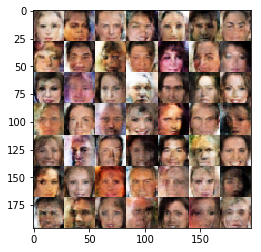

Epoch 1/1... Discriminator Loss: 0.0152... Generator Loss: 5.3979
Epoch 1/1... Discriminator Loss: 0.7791... Generator Loss: 0.8738
Epoch 1/1... Discriminator Loss: 0.9142... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 0.6688... Generator Loss: 0.9617
Epoch 1/1... Discriminator Loss: 2.6532... Generator Loss: 0.1955


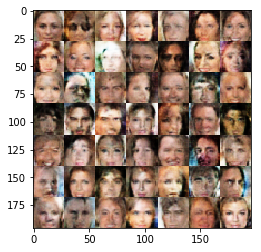

Epoch 1/1... Discriminator Loss: 0.3703... Generator Loss: 1.7095
Epoch 1/1... Discriminator Loss: 0.4558... Generator Loss: 1.5050
Epoch 1/1... Discriminator Loss: 0.0188... Generator Loss: 6.6321
Epoch 1/1... Discriminator Loss: 0.1722... Generator Loss: 3.2062
Epoch 1/1... Discriminator Loss: 0.1677... Generator Loss: 3.3825


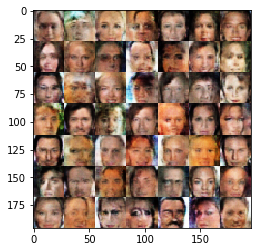

Epoch 1/1... Discriminator Loss: 0.1413... Generator Loss: 2.7090
Epoch 1/1... Discriminator Loss: 0.1633... Generator Loss: 2.5770
Epoch 1/1... Discriminator Loss: 0.0456... Generator Loss: 4.7131
Epoch 1/1... Discriminator Loss: 0.1776... Generator Loss: 2.7387
Epoch 1/1... Discriminator Loss: 0.1091... Generator Loss: 3.0697


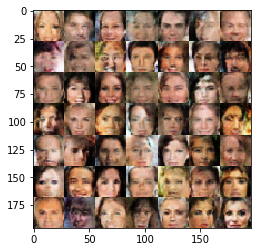

Epoch 1/1... Discriminator Loss: 0.0446... Generator Loss: 4.2588
Epoch 1/1... Discriminator Loss: 0.9301... Generator Loss: 0.7654
Epoch 1/1... Discriminator Loss: 0.2238... Generator Loss: 2.3447
Epoch 1/1... Discriminator Loss: 2.1698... Generator Loss: 4.0954
Epoch 1/1... Discriminator Loss: 0.1034... Generator Loss: 3.4409


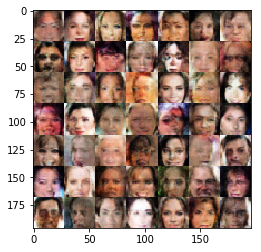

Epoch 1/1... Discriminator Loss: 0.0402... Generator Loss: 4.6898
Epoch 1/1... Discriminator Loss: 0.7777... Generator Loss: 0.8819
Epoch 1/1... Discriminator Loss: 0.0824... Generator Loss: 3.3836
Epoch 1/1... Discriminator Loss: 0.7311... Generator Loss: 1.1770
Epoch 1/1... Discriminator Loss: 0.6081... Generator Loss: 1.1737


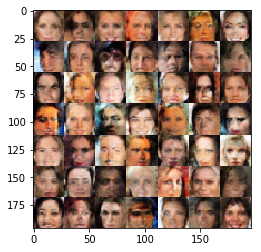

Epoch 1/1... Discriminator Loss: 0.4549... Generator Loss: 1.5472
Epoch 1/1... Discriminator Loss: 0.3080... Generator Loss: 1.6451
Epoch 1/1... Discriminator Loss: 1.4779... Generator Loss: 0.5901
Epoch 1/1... Discriminator Loss: 0.1637... Generator Loss: 2.9566
Epoch 1/1... Discriminator Loss: 3.2023... Generator Loss: 0.1782


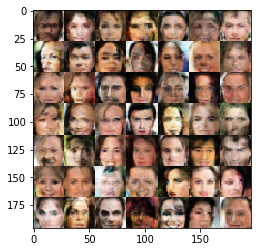

Epoch 1/1... Discriminator Loss: 0.2576... Generator Loss: 2.0829
Epoch 1/1... Discriminator Loss: 0.1597... Generator Loss: 3.2551
Epoch 1/1... Discriminator Loss: 0.3864... Generator Loss: 3.8372
Epoch 1/1... Discriminator Loss: 0.2536... Generator Loss: 2.1686
Epoch 1/1... Discriminator Loss: 0.3092... Generator Loss: 1.8987


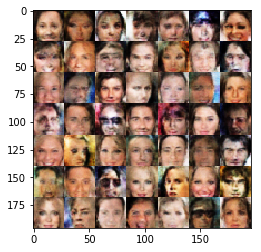

Epoch 1/1... Discriminator Loss: 0.0780... Generator Loss: 3.3250
Epoch 1/1... Discriminator Loss: 0.1724... Generator Loss: 2.5491
Epoch 1/1... Discriminator Loss: 1.6007... Generator Loss: 0.4222
Epoch 1/1... Discriminator Loss: 0.5798... Generator Loss: 1.0897
Epoch 1/1... Discriminator Loss: 0.3162... Generator Loss: 1.9141


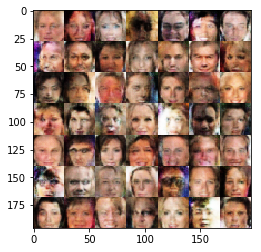

Epoch 1/1... Discriminator Loss: 0.6217... Generator Loss: 1.1991


In [ ]:
batch_size = 16
z_dim = 128
learning_rate = 0.0002
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.